In [1]:
import cv2
import os
import pandas as pd

import torch
from torch import nn
from PIL import Image
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms, datasets 

import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from efficientnet_pytorch import EfficientNet

In [2]:
from utils.Training_Functions import *
from utils.Models import *

In [3]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, basePath, low_res, high_res, EPOCHS, LR, batchSize, ):
        self.trainPath = basePath + "train/"
        self.testPath = basePath + "test/"
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.low_res = (low_res, low_res)
        self.high_res = (high_res, high_res)
        self.train_validate_percent = 0.95
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Configuration(basePath="../datasets/Retinal_OCT/", low_res=32, high_res=128, EPOCHS=500, LR=0.0001, batchSize=64 )

In [4]:
# Using transforms to augment data by randomizing in multiple ways, rotation, translation, and scaling
train_transform = transforms.Compose([
                                        transforms.Resize(size=config.high_res),
                                        # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Test and Validation transformations did not have the same modifications
test_transform = transforms.Compose([
                                        transforms.Resize(size=config.high_res),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [5]:
# Creates the initial ImageFolder dataset from the training path
train = SRGAN_Dataset(config.trainPath, low_res=config.low_res, transform=train_transform)

# Creates the initial ImageFolder dataset from the testing path
test = SRGAN_Dataset(config.testPath, low_res=config.low_res, transform=test_transform)

# Prints infomation about the datasets
print("\nTraining Dataset\n", len(train))
print("\nTesting Dataset\n", len(test))


Training Dataset
 19112

Testing Dataset
 930


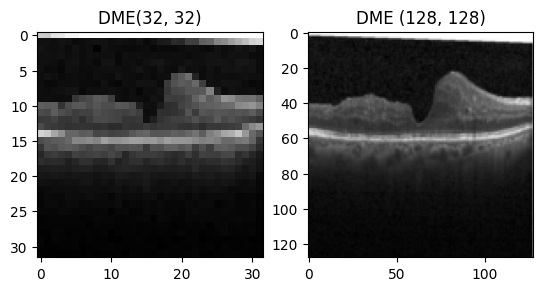

In [6]:
# Precalculated the number each class to ensure a balanced dataset
classTrainCount = {"DME":10847, "DRUSEN":8265} 

# Sets string definitions based on integer values
definitions = {0:"DME", 1:"DRUSEN"}

img_low, img_high, label = train[0]
img_low = np.array(img_low.permute(1,2,0))
img_high = np.array(img_high).transpose((1, 2, 0))

# Normalize the pixel values to the range [0, 1] for visualization
img_low = (img_low - img_low.min()) / (img_low.max() - img_low.min())
img_high = (img_high - img_high.min()) / (img_high.max() - img_high.min())

# View some of the training data
fig, axes = plt.subplots(nrows=1, ncols=2)

# Plot the data on the subplots
axes[0].imshow(img_low)
axes[0].set_title(f"{definitions[label]}{config.low_res}")

axes[1].imshow(img_high)
axes[1].set_title(f"{definitions[label]} {config.high_res}")
plt.show()

In [7]:
# Create all three dataloaders for the training, validating, and testing datasets
trainLoader = DataLoader(train, batch_size=config.bs, shuffle=True, num_workers=0)
testLoader = DataLoader(test, batch_size=1, shuffle=False, num_workers=0)

In [8]:
Generator = SR_Generator( body_arch= [(5,64)]).to(config.device)
test_input = torch.rand(1,3,32,32).to(config.device)
print("Output Size:", Generator(test_input).shape, "\n")
Discriminator = SR_Discriminator(body_arch= [
    (3, 64, 1), (3, 64, 2),
    (3, 128, 1), (3, 128, 2),
    (3, 256, 1), (3, 256, 2),
    (3, 512, 1), (3, 512, 2)
]).to(config.device)
test_input = torch.rand(1,3,128,128).to(config.device)
print("Output Size:", Discriminator(test_input).shape, "\n")

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Output Size: torch.Size([1, 3, 128, 128]) 

Output Size: torch.Size([1, 1]) 



In [ ]:
Train_SRGAN(Generator, Discriminator, GeneratorLoss(), DiscriminatorLoss(), trainLoader, testLoader, config.lr*0.1, 450, e_start=50, device=config.device)

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 51 - Generator Loss: 1.020756379019058, Discriminator Loss: 0.4343725783644512


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 52 - Generator Loss: 3.5261224360769012, Discriminator Loss: 0.035841076071047064


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 53 - Generator Loss: 4.66900671764361, Discriminator Loss: 0.011995849261888892


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 54 - Generator Loss: 5.386228901885425, Discriminator Loss: 0.006887151638939852


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 55 - Generator Loss: 5.898126176368432, Discriminator Loss: 0.004263510799267482


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 56 - Generator Loss: 6.333986803839438, Discriminator Loss: 0.002908871441096049


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 57 - Generator Loss: 6.722886788805193, Discriminator Loss: 0.0020127260972228663


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 58 - Generator Loss: 7.075499906189067, Discriminator Loss: 0.0014003699833844915


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 59 - Generator Loss: 7.420938853037398, Discriminator Loss: 0.0009822763367201728


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60 - Generator Loss: 7.659621138237791, Discriminator Loss: 0.0007567096613137282


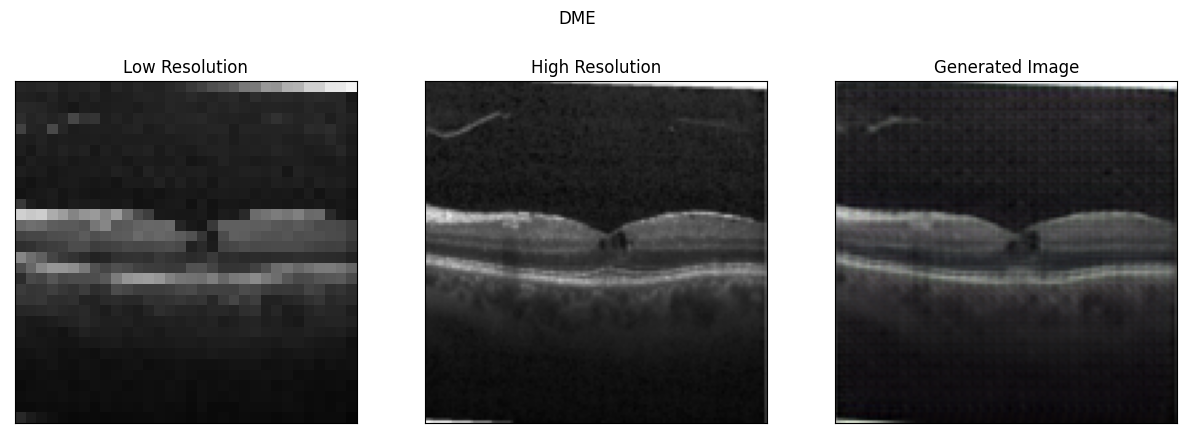

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 61 - Generator Loss: 7.894005145516284, Discriminator Loss: 0.0005320423159989322


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 62 - Generator Loss: 8.240860746058333, Discriminator Loss: 0.0004155955057255192


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 63 - Generator Loss: 8.374782705785439, Discriminator Loss: 0.00033697846109220016


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 64 - Generator Loss: 8.702049217096539, Discriminator Loss: 0.00022573659305903052


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 65 - Generator Loss: 8.99503644094818, Discriminator Loss: 0.0001647614109276636


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 66 - Generator Loss: 9.205572989473374, Discriminator Loss: 0.00014998069316813376


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 67 - Generator Loss: 9.394381537485282, Discriminator Loss: 0.00011538779685709059


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 68 - Generator Loss: 9.495355559830681, Discriminator Loss: 0.00012873527698183197


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 69 - Generator Loss: 9.771616908618837, Discriminator Loss: 8.017228519382718e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 70 - Generator Loss: 9.887413380536746, Discriminator Loss: 0.00014086743818327258


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 71 - Generator Loss: 9.814309836231347, Discriminator Loss: 0.0002288141612336896


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 72 - Generator Loss: 10.208730102781468, Discriminator Loss: 6.363195120152082e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 73 - Generator Loss: 9.933574890213269, Discriminator Loss: 0.0001510700341248253


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 74 - Generator Loss: 10.289699350312402, Discriminator Loss: 7.344921408712191e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 75 - Generator Loss: 10.430628060497169, Discriminator Loss: 4.312044790934802e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 76 - Generator Loss: 10.653044107366965, Discriminator Loss: 3.3476397547503234e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 77 - Generator Loss: 10.848136072573455, Discriminator Loss: 2.5544732068093226e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 78 - Generator Loss: 10.865375844132542, Discriminator Loss: 3.399185309483505e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 79 - Generator Loss: 11.075272207674773, Discriminator Loss: 2.2405601460173712e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80 - Generator Loss: 11.270571246194999, Discriminator Loss: 1.8384868325632743e-05


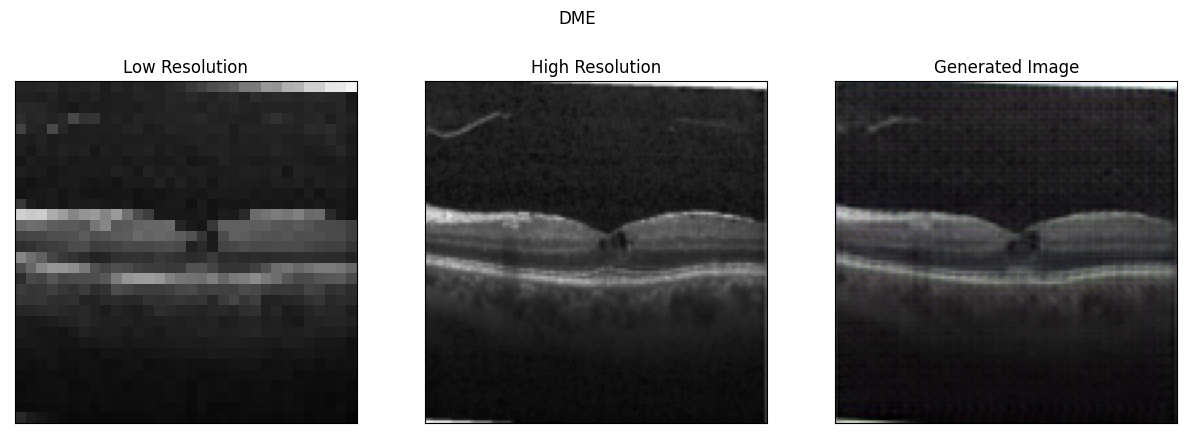

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 81 - Generator Loss: 11.498765135289833, Discriminator Loss: 1.3627608512610685e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 82 - Generator Loss: 11.621870114253117, Discriminator Loss: 1.3121188730122756e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 83 - Generator Loss: 11.788249119468357, Discriminator Loss: 1.2211021513671174e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 84 - Generator Loss: 11.88880737968113, Discriminator Loss: 9.027536033922736e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 85 - Generator Loss: 12.07073168611048, Discriminator Loss: 8.01954811520219e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 86 - Generator Loss: 12.109884354581801, Discriminator Loss: 9.118661948733738e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 87 - Generator Loss: 12.332024835822574, Discriminator Loss: 7.250423615449376e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 88 - Generator Loss: 11.897666623361134, Discriminator Loss: 3.11584027238733e-05


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 89 - Generator Loss: 12.520923770789718, Discriminator Loss: 5.480393930501667e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 90 - Generator Loss: 12.738165836270438, Discriminator Loss: 4.195522535420396e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 91 - Generator Loss: 12.940124712660161, Discriminator Loss: 3.74877872412643e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 92 - Generator Loss: 13.013656571557291, Discriminator Loss: 3.5619349478643276e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 93 - Generator Loss: 13.216800431344023, Discriminator Loss: 2.5763643736581038e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 94 - Generator Loss: 13.31351667423312, Discriminator Loss: 2.5407391816873963e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 95 - Generator Loss: 13.45064881493814, Discriminator Loss: 2.1054035695621215e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 96 - Generator Loss: 13.574187907088161, Discriminator Loss: 1.8964095853831917e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 97 - Generator Loss: 13.727810266424582, Discriminator Loss: 1.596103336080896e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 98 - Generator Loss: 13.78119520678568, Discriminator Loss: 1.9858309113079487e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 99 - Generator Loss: 13.926266239638313, Discriminator Loss: 1.5861084439607066e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100 - Generator Loss: 14.124169400703149, Discriminator Loss: 1.2305888670346236e-06


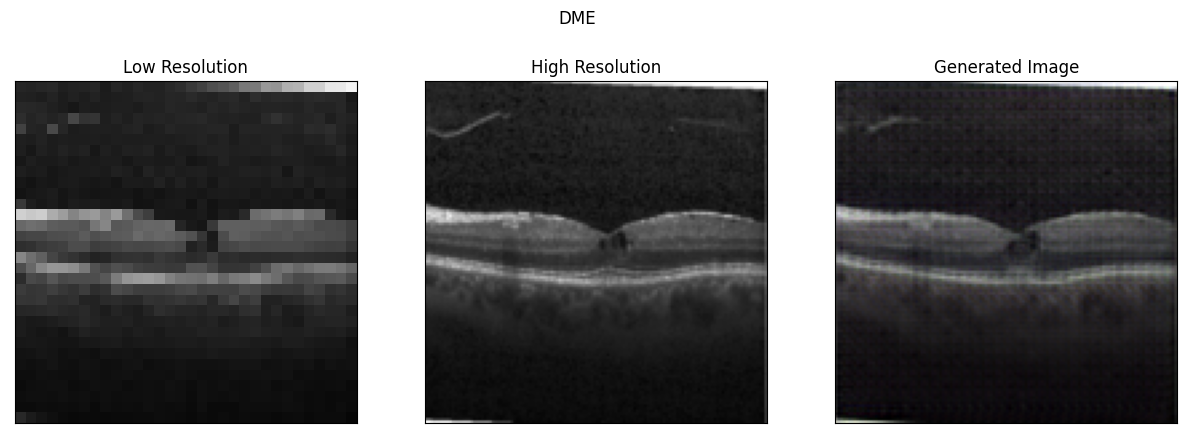

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 101 - Generator Loss: 14.316899430392976, Discriminator Loss: 1.0314079878687768e-06


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 102 - Generator Loss: 14.464497008052557, Discriminator Loss: 9.204664869240974e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 103 - Generator Loss: 14.628954013454475, Discriminator Loss: 6.703218214582735e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 104 - Generator Loss: 14.747824088386867, Discriminator Loss: 7.021281852292002e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 105 - Generator Loss: 14.794824166441442, Discriminator Loss: 6.871506542248398e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 106 - Generator Loss: 15.047738103962264, Discriminator Loss: 4.6703921261930955e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 107 - Generator Loss: 15.182680165089891, Discriminator Loss: 3.891101435085169e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 108 - Generator Loss: 15.364066018707378, Discriminator Loss: 3.8875839195309765e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 109 - Generator Loss: 15.440734834575334, Discriminator Loss: 3.8856077150614927e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 110 - Generator Loss: 15.549228186591414, Discriminator Loss: 7.221647883661648e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 111 - Generator Loss: 15.412581022766522, Discriminator Loss: 5.076443744059514e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 112 - Generator Loss: 15.736779589318113, Discriminator Loss: 2.8633683009041875e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 113 - Generator Loss: 15.946707173733408, Discriminator Loss: 2.4916321953423847e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 114 - Generator Loss: 16.212722446607508, Discriminator Loss: 1.6670052213089604e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 115 - Generator Loss: 16.241205633284654, Discriminator Loss: 1.6901554855934933e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 116 - Generator Loss: 16.248662683876063, Discriminator Loss: 2.8691961819136276e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 117 - Generator Loss: 16.11038698878974, Discriminator Loss: 1.8805411161095544e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 118 - Generator Loss: 16.5950565561403, Discriminator Loss: 1.2765179426914107e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 119 - Generator Loss: 16.799768789157422, Discriminator Loss: 1.0292993688443127e-07


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 120 - Generator Loss: 17.08648738095593, Discriminator Loss: 6.393385351567753e-08


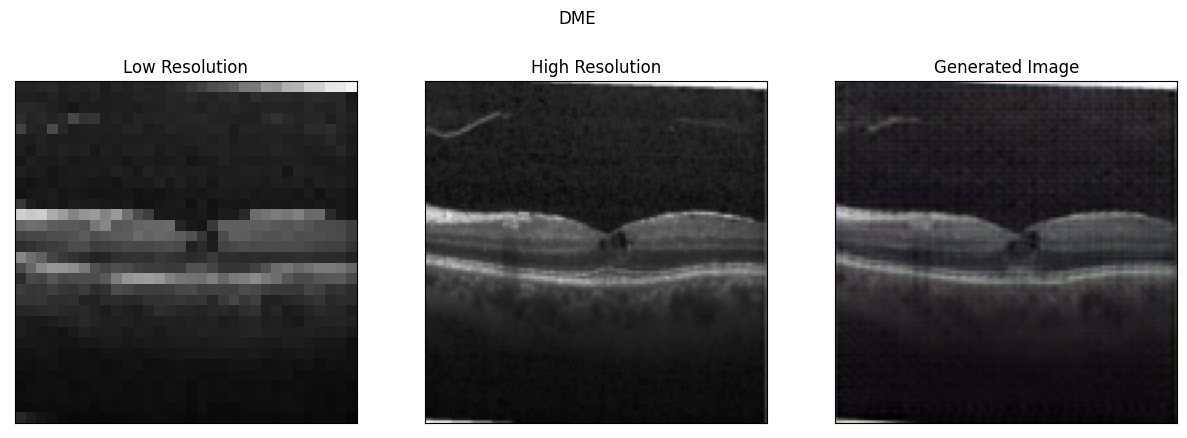

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 121 - Generator Loss: 17.24016556691964, Discriminator Loss: 5.8364064178388626e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 122 - Generator Loss: 17.37532157004876, Discriminator Loss: 5.218529894834696e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 123 - Generator Loss: 17.50402379434643, Discriminator Loss: 4.840759374395036e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 124 - Generator Loss: 17.949355450760958, Discriminator Loss: 4.4852131848779664e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 125 - Generator Loss: 17.975059145669075, Discriminator Loss: 3.8356073901182906e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 126 - Generator Loss: 18.414519593867173, Discriminator Loss: 2.9189713138970465e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 127 - Generator Loss: 18.019564319215092, Discriminator Loss: 3.0165309863521186e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 128 - Generator Loss: 18.616846802242623, Discriminator Loss: 3.127889938066402e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 129 - Generator Loss: 18.493051630996142, Discriminator Loss: 4.446430453893653e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 130 - Generator Loss: 19.528670888281987, Discriminator Loss: 3.2704722919796206e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 131 - Generator Loss: 19.790128484617508, Discriminator Loss: 2.1623580782878467e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 132 - Generator Loss: 20.467688263858044, Discriminator Loss: 1.9683377949106786e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 133 - Generator Loss: 20.76089597466, Discriminator Loss: 1.8381681808041145e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 134 - Generator Loss: 21.774134189388825, Discriminator Loss: 1.3554656966889265e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 135 - Generator Loss: 22.440102197653474, Discriminator Loss: 1.3145069523031875e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 136 - Generator Loss: 23.078841458196226, Discriminator Loss: 1.298684513848989e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 137 - Generator Loss: 22.618609881321323, Discriminator Loss: 8.973097691856653e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 138 - Generator Loss: 25.364286569448616, Discriminator Loss: 9.873906327641964e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 139 - Generator Loss: 22.750901604974548, Discriminator Loss: 1.2803158809243634e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 140 - Generator Loss: 24.783561011221895, Discriminator Loss: 7.143473856291308e-09


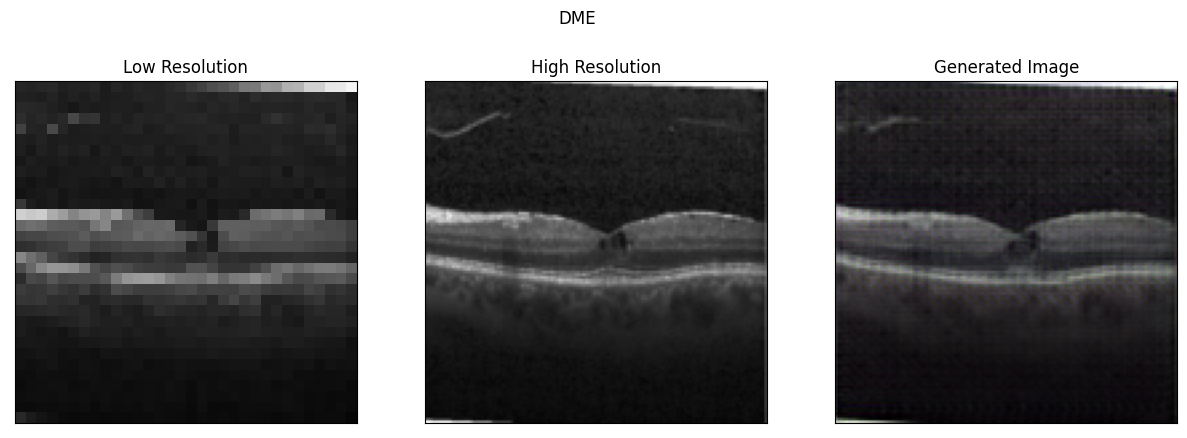

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 141 - Generator Loss: 24.657871383488377, Discriminator Loss: 1.144487914825716e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 142 - Generator Loss: 26.142725714871716, Discriminator Loss: 7.311361764437802e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 143 - Generator Loss: 30.20015529007417, Discriminator Loss: 6.754436634307426e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 144 - Generator Loss: 28.946807194712967, Discriminator Loss: 6.124310549588974e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 145 - Generator Loss: 29.032744302398783, Discriminator Loss: 5.15965577918145e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 146 - Generator Loss: 31.255682607159567, Discriminator Loss: 4.846622010821155e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 147 - Generator Loss: 32.10702390256135, Discriminator Loss: 4.211512028378604e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 148 - Generator Loss: 34.90395591251029, Discriminator Loss: 3.7844744588215305e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 149 - Generator Loss: 37.55221755050098, Discriminator Loss: 3.93180628133465e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 150 - Generator Loss: 34.73511078046716, Discriminator Loss: 4.760963689062563e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 151 - Generator Loss: 41.885111059233495, Discriminator Loss: 3.207614563221437e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 152 - Generator Loss: 42.74738620515651, Discriminator Loss: 2.4653581250056716e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 153 - Generator Loss: 42.06093513845999, Discriminator Loss: 2.2255190351315543e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 154 - Generator Loss: 48.90848242080331, Discriminator Loss: 2.441998230904846e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 155 - Generator Loss: 48.2031604996493, Discriminator Loss: 2.012155746370418e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 156 - Generator Loss: 46.83817183453104, Discriminator Loss: 1.9507942574592316e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 157 - Generator Loss: 44.7112339683201, Discriminator Loss: 3.75178228803758e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 158 - Generator Loss: 44.683663875362946, Discriminator Loss: 2.294044548154695e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 159 - Generator Loss: 36.15056418415695, Discriminator Loss: 1.7938877047883732e-08


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 160 - Generator Loss: 39.846184350973786, Discriminator Loss: 6.55044332785399e-09


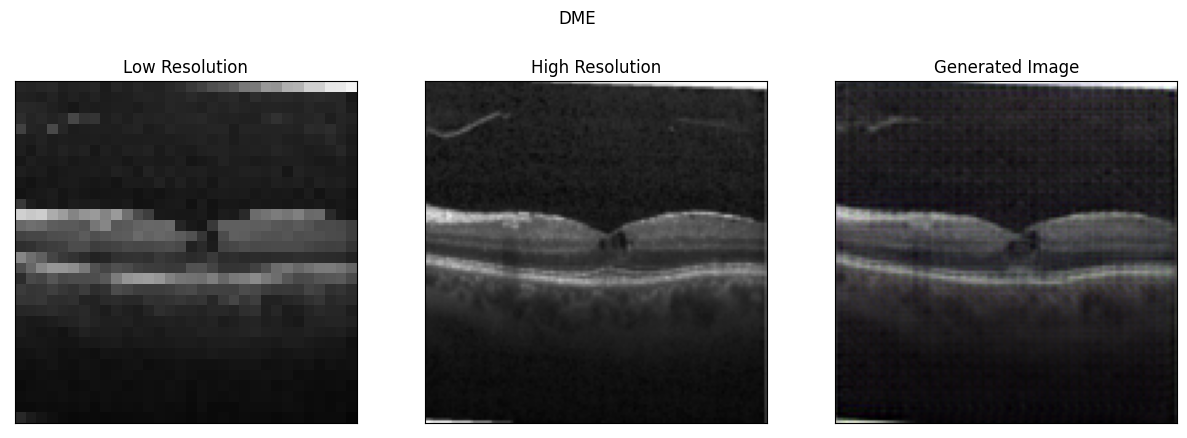

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 161 - Generator Loss: 50.455415735276645, Discriminator Loss: 4.496543196128978e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 162 - Generator Loss: 51.91886018989078, Discriminator Loss: 1.755185379794361e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 163 - Generator Loss: 50.64824136204544, Discriminator Loss: 2.0246170797105796e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 164 - Generator Loss: 54.66367094492833, Discriminator Loss: 1.5838718478721422e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 165 - Generator Loss: 56.014583804535626, Discriminator Loss: 1.2786220462197595e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 166 - Generator Loss: 57.03727696651599, Discriminator Loss: 1.5119202066458591e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 167 - Generator Loss: 58.96152014716413, Discriminator Loss: 1.2568185834312691e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 168 - Generator Loss: 58.43458007889049, Discriminator Loss: 1.2396872599440111e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 169 - Generator Loss: 61.621616127498974, Discriminator Loss: 1.1976375257551285e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 170 - Generator Loss: 59.23948270102409, Discriminator Loss: 1.2733270437676526e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 171 - Generator Loss: 64.06394576388458, Discriminator Loss: 8.830434380740398e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 172 - Generator Loss: 65.38576587307014, Discriminator Loss: 9.422245629576611e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 173 - Generator Loss: 65.58049973197605, Discriminator Loss: 1.321606484228003e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 174 - Generator Loss: 65.69607982188961, Discriminator Loss: 8.285346786206883e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 175 - Generator Loss: 68.32216119287803, Discriminator Loss: 8.082884736851528e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 176 - Generator Loss: 69.41420824312446, Discriminator Loss: 6.587784197752185e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 177 - Generator Loss: 68.38920347666661, Discriminator Loss: 6.369748912644954e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 178 - Generator Loss: 69.93590293042237, Discriminator Loss: 9.42224715566913e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 179 - Generator Loss: 71.31237753418377, Discriminator Loss: 5.34186755773434e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 180 - Generator Loss: 73.67270691657943, Discriminator Loss: 6.369749350793171e-10


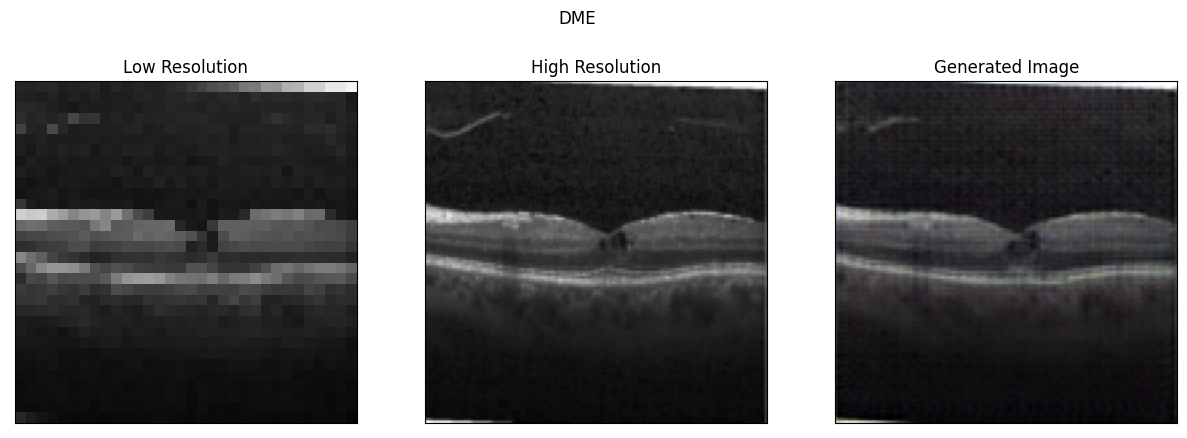

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 181 - Generator Loss: 73.88141276764631, Discriminator Loss: 9.665201413273115e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 182 - Generator Loss: 73.4048531382379, Discriminator Loss: 6.743525028611878e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 183 - Generator Loss: 67.33112352428628, Discriminator Loss: 8.381911081228561e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 184 - Generator Loss: 70.80246670190307, Discriminator Loss: 5.232849961594731e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 185 - Generator Loss: 74.0053320600835, Discriminator Loss: 4.781205297897564e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 186 - Generator Loss: 73.71600259506583, Discriminator Loss: 5.391704544742763e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 187 - Generator Loss: 75.0435361957869, Discriminator Loss: 6.444506103049571e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 188 - Generator Loss: 75.02792912741569, Discriminator Loss: 4.781205175364588e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 189 - Generator Loss: 78.18177811357887, Discriminator Loss: 5.466459544406295e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 190 - Generator Loss: 72.87300079243637, Discriminator Loss: 1.2770704757534494e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 191 - Generator Loss: 73.14535051683917, Discriminator Loss: 7.241892191831274e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 192 - Generator Loss: 76.61930210534545, Discriminator Loss: 5.108258795522403e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 193 - Generator Loss: 76.07881255133894, Discriminator Loss: 5.559903630023113e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 194 - Generator Loss: 77.98942065797124, Discriminator Loss: 3.634961737034529e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 195 - Generator Loss: 79.30109887139055, Discriminator Loss: 3.737749972037219e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 196 - Generator Loss: 77.40602943650057, Discriminator Loss: 5.939909244512414e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 197 - Generator Loss: 79.49385031250408, Discriminator Loss: 6.525491005965612e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 198 - Generator Loss: 77.15422787235732, Discriminator Loss: 5.413508747556166e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 199 - Generator Loss: 80.91297075022821, Discriminator Loss: 4.313988478966583e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 200 - Generator Loss: 81.97148647116977, Discriminator Loss: 3.457418847688512e-10


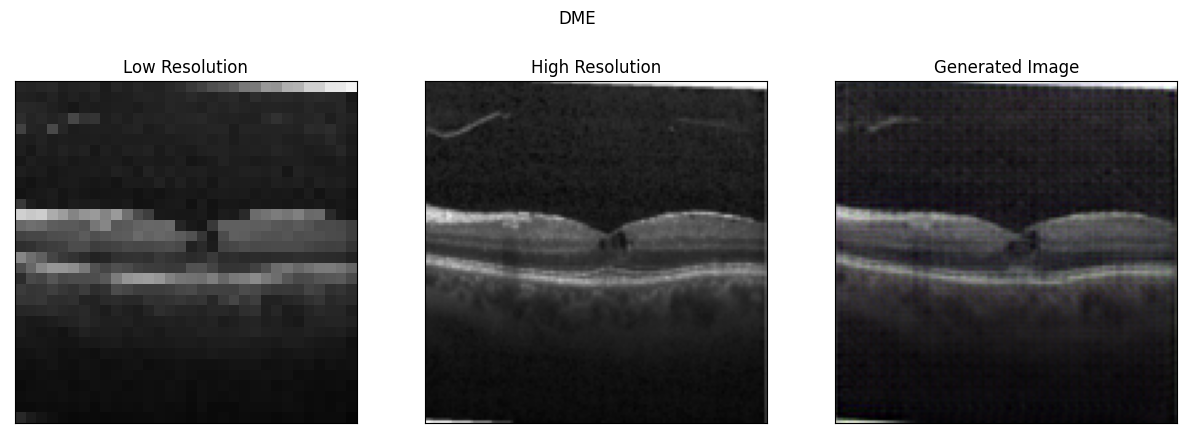

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 201 - Generator Loss: 81.65872008664951, Discriminator Loss: 4.313986945447823e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 202 - Generator Loss: 80.91292646018957, Discriminator Loss: 3.659881056708048e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 203 - Generator Loss: 80.6535371123349, Discriminator Loss: 3.052495796077778e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 204 - Generator Loss: 81.17618594600205, Discriminator Loss: 3.3016792347323373e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 205 - Generator Loss: 84.58906063985665, Discriminator Loss: 3.0836437416903597e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 206 - Generator Loss: 83.29984613884253, Discriminator Loss: 3.021348028694979e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 207 - Generator Loss: 81.95498932165445, Discriminator Loss: 3.529059196488548e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 208 - Generator Loss: 84.38188559235537, Discriminator Loss: 2.1180582260212232e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 209 - Generator Loss: 86.1977930228447, Discriminator Loss: 3.1770878235940575e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 210 - Generator Loss: 84.62142210102401, Discriminator Loss: 2.8500345747482904e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 211 - Generator Loss: 87.26033345353244, Discriminator Loss: 3.0057743696473693e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 212 - Generator Loss: 87.28018975018658, Discriminator Loss: 2.354782730754077e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 213 - Generator Loss: 85.94023340282632, Discriminator Loss: 2.616425099617221e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 214 - Generator Loss: 84.30845455182435, Discriminator Loss: 4.6410406175893254e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 215 - Generator Loss: 85.66953178711958, Discriminator Loss: 2.494948146260172e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 216 - Generator Loss: 84.89194385822003, Discriminator Loss: 3.0369222335713e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 217 - Generator Loss: 87.54929971216514, Discriminator Loss: 1.7131353415009108e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 218 - Generator Loss: 87.79667195986744, Discriminator Loss: 2.4606858245550105e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 219 - Generator Loss: 87.56320856406936, Discriminator Loss: 1.6352655684409077e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 220 - Generator Loss: 81.63977575142647, Discriminator Loss: 5.637774635839116e-10


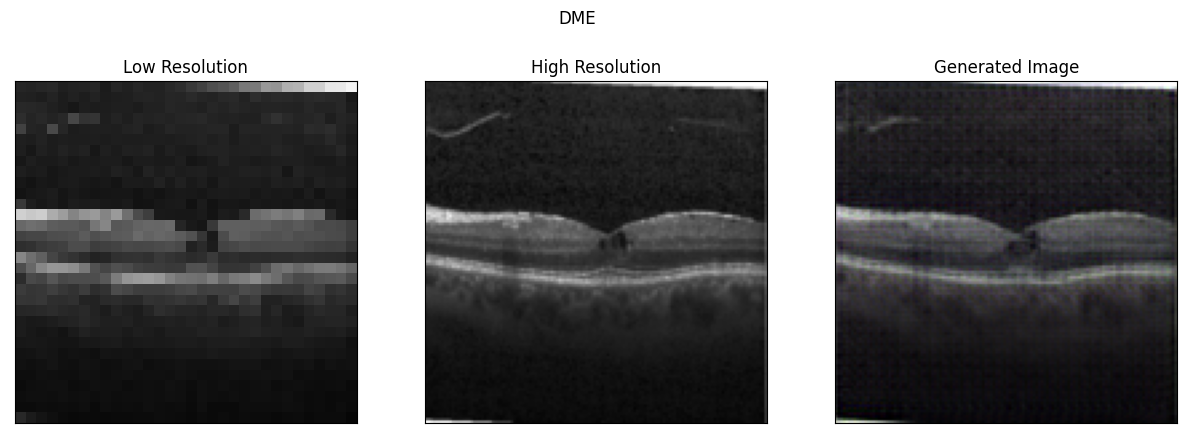

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 221 - Generator Loss: 83.02044229922087, Discriminator Loss: 4.2828416621426277e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 222 - Generator Loss: 87.5704000658016, Discriminator Loss: 1.5885436890097997e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 223 - Generator Loss: 88.8568670470579, Discriminator Loss: 2.398389966747931e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 224 - Generator Loss: 88.86710832270491, Discriminator Loss: 2.1803543660254595e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 225 - Generator Loss: 88.07288183256934, Discriminator Loss: 1.9778928253676105e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 226 - Generator Loss: 88.06543163312318, Discriminator Loss: 2.2893718693370563e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 227 - Generator Loss: 88.58972492664554, Discriminator Loss: 2.429537570753428e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 228 - Generator Loss: 90.17625545259304, Discriminator Loss: 2.32051990406453e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 229 - Generator Loss: 88.61286988784637, Discriminator Loss: 1.6819874924294614e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 230 - Generator Loss: 90.19147890786263, Discriminator Loss: 1.759857261776344e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 231 - Generator Loss: 88.0538664852895, Discriminator Loss: 3.4262724244553285e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 232 - Generator Loss: 88.0972228161866, Discriminator Loss: 1.5729697069207078e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 233 - Generator Loss: 88.62687837479506, Discriminator Loss: 1.4483780470033558e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 234 - Generator Loss: 87.26045971490866, Discriminator Loss: 4.3700567486517746e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 235 - Generator Loss: 88.60982110269093, Discriminator Loss: 2.040188582920437e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 236 - Generator Loss: 90.9909688126682, Discriminator Loss: 1.463952036518689e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 237 - Generator Loss: 87.0142043187068, Discriminator Loss: 2.0557624907471194e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 238 - Generator Loss: 90.46180199460441, Discriminator Loss: 1.5729697997487196e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 239 - Generator Loss: 89.9567937563893, Discriminator Loss: 1.3860823191554932e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 240 - Generator Loss: 89.15204286096885, Discriminator Loss: 1.354934317846104e-10


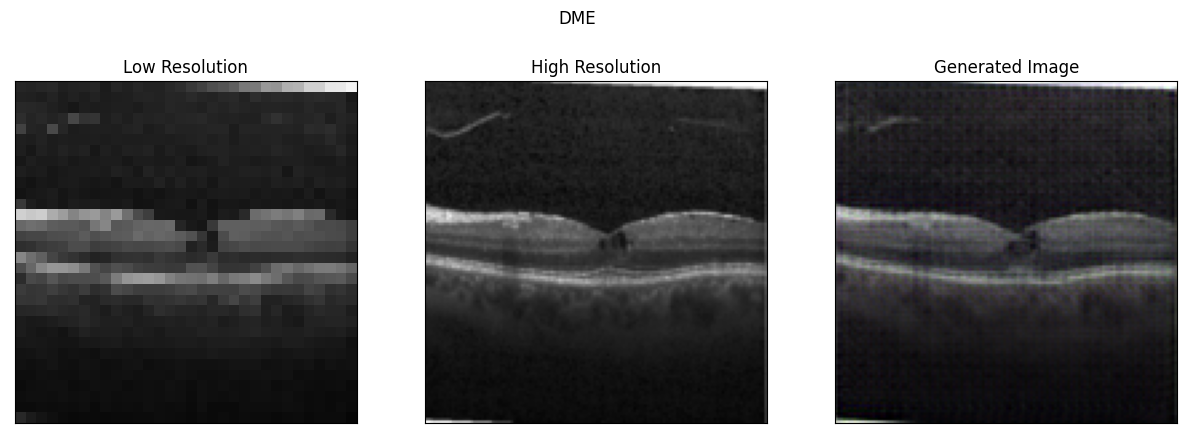

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 241 - Generator Loss: 89.663077861569, Discriminator Loss: 1.713135434328923e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 242 - Generator Loss: 88.31195867659655, Discriminator Loss: 3.0524969285795257e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 243 - Generator Loss: 89.3806087595962, Discriminator Loss: 2.024614548847658e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 244 - Generator Loss: 90.45181493854842, Discriminator Loss: 1.681987436732654e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 245 - Generator Loss: 89.6602065555228, Discriminator Loss: 2.585277866923772e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 246 - Generator Loss: 87.5469576092468, Discriminator Loss: 1.9000228369466193e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 247 - Generator Loss: 89.42871216866483, Discriminator Loss: 1.370508337066401e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 248 - Generator Loss: 90.99221174055118, Discriminator Loss: 1.3082124421281164e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 249 - Generator Loss: 90.98700361985426, Discriminator Loss: 1.5044443561609323e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 250 - Generator Loss: 90.46280233836094, Discriminator Loss: 1.4639520439449298e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 251 - Generator Loss: 88.62458114241278, Discriminator Loss: 1.635265579580269e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 252 - Generator Loss: 90.72157577208452, Discriminator Loss: 1.5729698517324065e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 253 - Generator Loss: 92.04086392380322, Discriminator Loss: 1.8065792860191508e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 254 - Generator Loss: 89.67897477038329, Discriminator Loss: 1.3860822783111677e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 255 - Generator Loss: 90.96635089351182, Discriminator Loss: 1.993466818596064e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 256 - Generator Loss: 91.80310408805924, Discriminator Loss: 9.344374698023018e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 257 - Generator Loss: 90.47750818131361, Discriminator Loss: 1.41723022392375e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 258 - Generator Loss: 73.21628901312583, Discriminator Loss: 4.764456545011294e-09


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 259 - Generator Loss: 82.46394909504664, Discriminator Loss: 4.4697284149642395e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 260 - Generator Loss: 85.40291702627736, Discriminator Loss: 2.709868992151774e-10


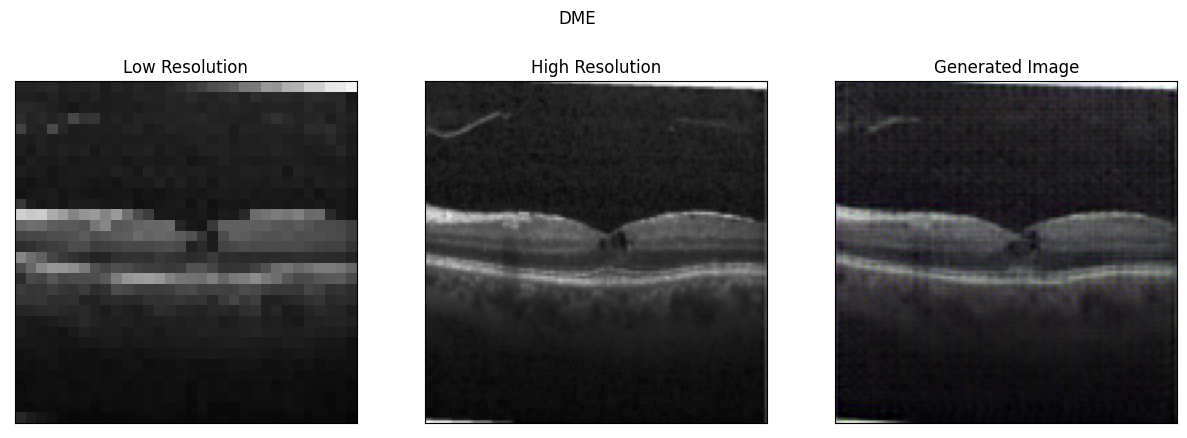

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 261 - Generator Loss: 85.17126587322325, Discriminator Loss: 2.189698543259735e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 262 - Generator Loss: 87.01583020264488, Discriminator Loss: 2.3983897885181476e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 263 - Generator Loss: 88.33555278331539, Discriminator Loss: 4.656621810558397e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 264 - Generator Loss: 87.56319453006604, Discriminator Loss: 1.79100516283148e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 265 - Generator Loss: 89.67425177966471, Discriminator Loss: 1.8221533497968935e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 266 - Generator Loss: 90.70921761375605, Discriminator Loss: 1.9311709050921772e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 267 - Generator Loss: 89.40539878028692, Discriminator Loss: 1.635265609285233e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 268 - Generator Loss: 91.2770304536341, Discriminator Loss: 1.8377272836154193e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 269 - Generator Loss: 91.79900659924766, Discriminator Loss: 1.5262484735725638e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 270 - Generator Loss: 92.57427313176287, Discriminator Loss: 1.230342665354993e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 271 - Generator Loss: 91.28952395716638, Discriminator Loss: 8.565676558979735e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 272 - Generator Loss: 92.60481186933741, Discriminator Loss: 8.565676558979735e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 273 - Generator Loss: 91.53662258645763, Discriminator Loss: 1.1524729108605923e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 274 - Generator Loss: 92.05676293133892, Discriminator Loss: 1.2147687278233466e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 275 - Generator Loss: 93.11646277768955, Discriminator Loss: 1.0123072317229435e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 276 - Generator Loss: 94.1735727125187, Discriminator Loss: 8.565676707504554e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 277 - Generator Loss: 93.39268238488647, Discriminator Loss: 8.721416119952223e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 278 - Generator Loss: 91.50788193004188, Discriminator Loss: 1.6508396619236144e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 279 - Generator Loss: 92.86275732876067, Discriminator Loss: 8.565676633242144e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 280 - Generator Loss: 93.64217303349422, Discriminator Loss: 1.3549346371744655e-10


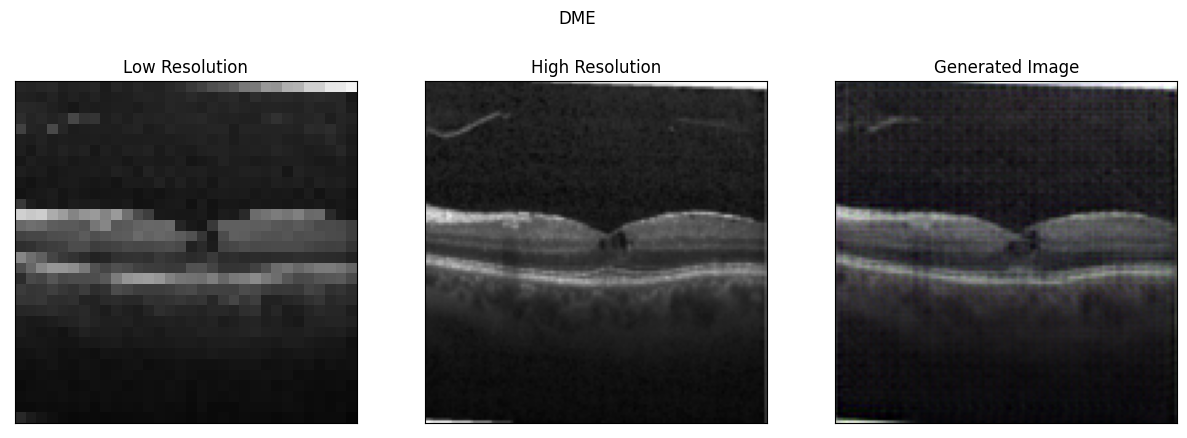

  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 281 - Generator Loss: 92.59844986012946, Discriminator Loss: 1.1213250655022634e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 282 - Generator Loss: 94.45800314300435, Discriminator Loss: 6.385322556840083e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 283 - Generator Loss: 93.92060170125802, Discriminator Loss: 7.008280874992445e-11


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 284 - Generator Loss: 92.58109648969261, Discriminator Loss: 1.1057509905851591e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 285 - Generator Loss: 91.52542249494572, Discriminator Loss: 1.2926385677195184e-10


  0%|          | 0/299 [00:00<?, ?it/s]

Epoch 286 - Generator Loss: 93.10335322606524, Discriminator Loss: 1.1057510091507616e-10


  0%|          | 0/299 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
Train_SRGAN(Generator, Discriminator, GeneratorLoss(), DiscriminatorLoss(), trainLoader, testLoader, config.lr*0.1, 450, e_start=50, device=config.device)

In [21]:
torch.save(Generator.state_dict(), 'generator_model.pth')
torch.save(Discriminator.state_dict(), 'discriminator_model.pth')